In [1]:
# 导入基本包
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
adults = pd.read_csv('/Users/fangcheng/KNN算法/adult.csv')
# adults = pd.read_csv('adult.csv')
adults.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [6]:
'''
算法选择：
    KNN：准确率较高，对异常数据不敏感
    Logisitc：准确率较高，效率也高
    NB：比较适合解决目标字段间存在因果关系的离散型数据
'''

'\n算法选择：\n    KNN：准确率较高，对异常数据不敏感\n    Logisitc：准确率较高，效率也高\n    NB：比较适合解决目标字段间存在因果关系的离散型数据\n'

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [10]:
train = adults.drop('sex', axis=1).copy()
target = adults.sex.copy()

In [16]:
# 原始数据的清洗
# 1、对相近的词进行真个成相同的词
# 2、整合后的字段内容是否存在有序关系
# 如果有序，应该强调数据的大小
# 如果无序，消除数据之间的大小（独热编码）
train.workclass.unique()

array(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [18]:
# 特征选择（经验+算法）
X = train[["workclass", "race", "hours.per.week"]].copy()
X

,workclass,race,hours.per.week
0,?,White,40
1,Private,White,18
2,?,Black,40
3,Private,White,40
4,Private,White,40
...,...,...,...
32556,Private,White,40
32557,Private,White,38
32558,Private,White,40
32559,Private,White,40


In [19]:
X.dtypes

workclass         object
race              object
hours.per.week     int64
dtype: object

In [21]:
# 数值映射
unique_arr = X.race.unique()
def map_race(x):
    index = np.argwhere(x == unique_arr)[0,0]
    return index
X.race = X.race.map(map_race)

In [22]:
unique_arr = X.workclass.unique()
def map_workclass(x):
    index = np.argwhere(x == unique_arr)[0,0]
    return index
X.workclass = X.workclass.map(map_workclass)

In [23]:
X.head()

,workclass,race,hours.per.week
0,0,0,40
1,1,0,18
2,0,1,40
3,1,0,40
4,1,0,40


In [26]:
y = target.map({"Male":0, "Female":1}).copy()
y

0        1
1        1
2        1
3        1
4        1
        ..
32556    0
32557    1
32558    0
32559    1
32560    0
Name: sex, Length: 32561, dtype: int64

<AxesSubplot:xlabel='sex', ylabel='count'>

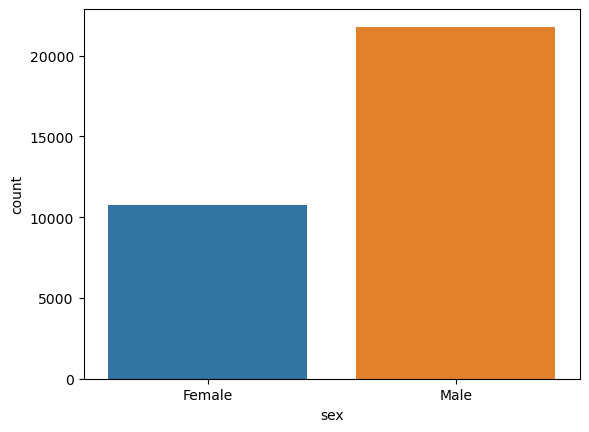

In [80]:
# 查看数据分布
'''
过采样：（样本均衡）
欠采样：（样本均衡）在样本数量多的那一类随机选择
重采样：（时间分组）
'''
sns.countplot(target)

In [81]:
target.value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [82]:
# 生成一组随机索引0-21790直接随机选择10771个
random_index = np.random.permutation(21790)[:10771]

In [83]:
# 先把Male数据获取出来，再在这个子集中随机选择10771个
Male_y = target[target == "Male"].iloc[random_index]
Male_X = X[target == "Male"].iloc[random_index]

In [84]:
# 先把Female数据获取出来，再在这个子集中随机选择10771个
Female_y = target[target == "Female"]
Female_X = X[target == "Female"]

In [85]:
# 整合过滤出来的数据重新形成新的数据集
GX = pd.concat((Male_X, Female_X))
Gy = pd.concat((Male_y, Female_y))

In [86]:
Gy.shape

(21542,)

In [96]:
Gy = Gy.map({"Male":0, "Female":1}).copy()

In [97]:
Gy.head()

21072    0
17117    0
2836     0
7014     0
8600     0
Name: sex, dtype: int64

In [98]:
GX.shape

(21542, 3)

In [99]:
Gy.value_counts()

0    10771
1    10771
Name: sex, dtype: int64

In [100]:
# 创建基模型--base_model
from sklearn.model_selection import cross_val_score

In [127]:
base_knn = KNeighborsClassifier()
base_lr = LogisticRegression()
base_gnb = GaussianNB()
base_mnb = MultinomialNB()

In [128]:
cross_val_score(base_knn, GX, Gy, cv=3).mean()

0.5230710374289317

In [129]:
cross_val_score(base_lr, GX, Gy, cv=3).mean()

0.6212051507531028

In [130]:
cross_val_score(base_gnb, GX, Gy, cv=3).mean()

0.6151239336446624

In [131]:
cross_val_score(base_mnb, GX, Gy, cv=3).mean()

0.5392257526793921

In [132]:
# 调参

In [133]:
from sklearn.model_selection import GridSearchCV

In [134]:
GX.shape

(21542, 3)

In [135]:
np.sqrt(21542*0.7)

122.79820845598685

In [136]:
Gy

21072    0
17117    0
2836     0
7014     0
8600     0
        ..
32547    1
32548    1
32550    1
32557    1
32559    1
Name: sex, Length: 21542, dtype: int64

In [137]:
# KNN调参

In [138]:
knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors":np.arange(61,95,6)
}
gscv = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3)
gscv.fit(GX, Gy)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([61, 67, 73, 79, 85, 91])})

In [139]:
gscv.best_params_

{'n_neighbors': 61}

In [140]:
cross_val_score(gscv.best_estimator_, GX, Gy, cv=3).mean()

0.5727880961533564

In [141]:
# Logistic 调整
lr = LogisticRegression()
param_grid = {
    "penalty":["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
}
gscv = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3)
gscv.fit(GX, Gy)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [142]:
gscv.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [143]:
cross_val_score(gscv.best_estimator_, GX, Gy, cv=3).mean()

0.6212051507531028

In [145]:
# Logistic 调整
lr = LogisticRegression()
param_grid = {
    "penalty":["l1", "l2"],
    "C":[0.5, 1, 1.5]
}
gscv = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3)
gscv.fit(GX, Gy)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 1.5], 'penalty': ['l1', 'l2']})

In [146]:
gscv.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [147]:
cross_val_score(gscv.best_estimator_, GX, Gy, cv=3).mean()

0.6212051507531028

In [ ]:
'''
还能做什么？
特征处理
1、字段选择（选择更多的字段）
2、字段本身的处理上（映射逻辑可以继续调整）
'''